In [1]:
import zarr
import numpy as np
from collections import defaultdict
from pathlib import Path

import torch
import torch.utils.data as torch_data
import os
import psutil
import gc

from matplotlib import pyplot as plt

def current_memory():
    process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss
    memory_usage_mb = memory_usage / (1024 ** 2)
    return memory_usage_mb

# memoery measurement

In [11]:
class ZarrDataset(torch_data.Dataset):
    def __init__(self, zarr_store_path='./memtest.zarr'):

        self.zarr_store_path = Path(zarr_store_path)
        self.store = zarr.storage.LocalStore(str(self.zarr_store_path))

        if not self.zarr_store_path.exists():
            
            zarr_data = zarr.create_array(store=self.store, 
                            name='data',
                            shape=(40000, 100),
                            chunks=(4000, 100),
                            dtype='f4',
                            compressors=None
                            )
            zarr_data[:] = np.random.rand(40000, 100)

        self.root = zarr.open(store=self.store, mode='r')

    def __len__(self):
        return self.root['data'].shape[0]
    
    def __getitem__(self, idx):
        return self.root['data'][idx]
    
    def reset_store(self):
        del self.root
        del self.store
        gc.collect()
        self.store = zarr.storage.LocalStore(str(self.zarr_store_path))
        self.root = zarr.open(store=self.store, mode='r')
    
dataset = ZarrDataset()

In [2]:
process = psutil.Process(os.getpid())
def current_memory():
    # process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss
    memory_usage_mb = memory_usage / (1024 ** 2)
    return memory_usage_mb

init_mem = current_memory()
mem_measurements = []
io_measurements = []

store = zarr.storage.LocalStore('./memtest.zarr')
root = zarr.open(store=store, mode='r')

print(root['data'].info)

batch_size=10
for i in range(0, root['data'].shape[0] - batch_size, batch_size):
    io_before = process.io_counters().read_bytes
    batch = root['data'][i:i+batch_size]
    io_after = process.io_counters().read_bytes
    mem_measurements.append(current_memory() - init_mem)
    io_measurements.append(io_after - io_before)


Type               : Array
Zarr format        : 3
Data type          : DataType.float32
Shape              : (40000, 100)
Chunk shape        : (4000, 100)
Order              : C
Read-only          : False
Store type         : LocalStore
Filters            : ()
Serializer         : BytesCodec(endian=<Endian.little: 'little'>)
Compressors        : ()
No. bytes          : 16000000 (15.3M)


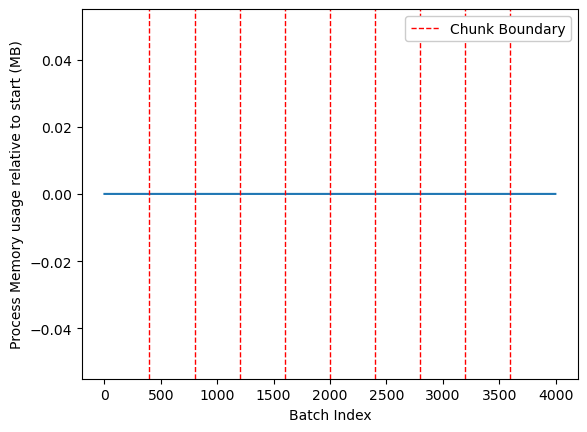

In [3]:
plt.plot(io_measurements)

# plot vertical lines every 1000 samples

start_idxs = np.arange(0, root['data'].shape[0] - batch_size, batch_size)
end_idxs = start_idxs + batch_size

chunk_boundaries = []
current_chunk = 0
for batch_idx, (start_idx, end_idx) in enumerate(zip(start_idxs, end_idxs)):
    start_chunk = start_idx // root['data'].chunks[0]
    end_chunk = end_idx // root['data'].chunks[0]
    if start_chunk != current_chunk or end_chunk != current_chunk:
        chunk_boundaries.append(batch_idx)
        current_chunk = end_chunk

for i , boundary_batch_idx in enumerate(chunk_boundaries):
    plt.axvline(x=boundary_batch_idx, color='r', linestyle='--', lw=1, label='Chunk Boundary' if i == 0 else None)
    

# plt.xlim(0, 10000)
legend = plt.legend(framealpha=1)
plt.xlabel('Batch Index')
plt.ylabel('Process Memory usage relative to start (MB)')
plt.show()

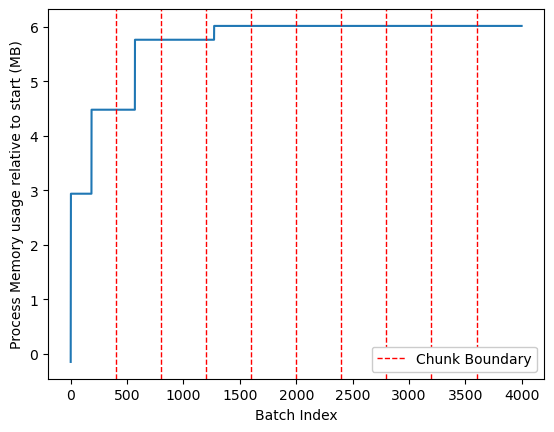

In [4]:
plt.plot(mem_measurements)

# plot vertical lines every 1000 samples

start_idxs = np.arange(0, root['data'].shape[0] - batch_size, batch_size)
end_idxs = start_idxs + batch_size

chunk_boundaries = []
current_chunk = 0
for batch_idx, (start_idx, end_idx) in enumerate(zip(start_idxs, end_idxs)):
    start_chunk = start_idx // root['data'].chunks[0]
    end_chunk = end_idx // root['data'].chunks[0]
    if start_chunk != current_chunk or end_chunk != current_chunk:
        chunk_boundaries.append(batch_idx)
        current_chunk = end_chunk

for i , boundary_batch_idx in enumerate(chunk_boundaries):
    plt.axvline(x=boundary_batch_idx, color='r', linestyle='--', lw=1, label='Chunk Boundary' if i == 0 else None)
    

# plt.xlim(0, 10000)
legend = plt.legend(framealpha=1)
plt.xlabel('Batch Index')
plt.ylabel('Process Memory usage relative to start (MB)')
plt.show()

# Conclusion!

Zarr keeps nothing in memory after reads. So everytime you access a piece of a chunk, the entire chunk is read into memory, and onlny what you asked for is returned. This is why the memory usage is somewhat constant and on the order of the chunk size. The IO usage is also constant and on the order of the chunk size. This is because the entire chunk is read into memory, and then the requested slice is returned. This is why the IO usage is constant and on the order of the chunk size.

# The solution!

We build a wrapper around our zarr data that caches chunks in memory. Something like this:

```python 
class MyStorage:

    def __init__(self, zarr_array):
        self._zarr_array = zarr_array
        self._chunksize = zarr_array.chunks[0]

    def load(self, i):
        """Load the ith element from the managed array."""
        chunknum, chunk_idx = divmod(i, self._chunksize)
        return self._load_chunk(chunknum)[chunkidx]

    @functools.lru_cache(cache_size)
    def _load_chunk(self, chunknum):
        return self._zarr_array[self._chunksize * chunknum:self._chunksize * (chunknum + 1)]
```